In [14]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from scipy.integrate import simps
import seaborn as sns
import scipy.stats as ss
from scipy.interpolate import  interp1d
from scipy import interpolate
import math
sns.set_theme()

<h1> Data indhentning

In [15]:
data_raw = np.genfromtxt('livechart3.csv', delimiter=',',skip_header=1)
data_pd = pd.DataFrame(data_raw)
data_without_nan = data_pd.dropna(subset=[7])
u235_proton = np.array(data_without_nan[0].values.tolist())
u235_nucleus = np.array(data_without_nan[1].values.tolist())
u235_yield = np.array(data_without_nan[7].values.tolist())/np.sum(np.array(data_without_nan[7].values.tolist()))

In [16]:
#Data for atomic mass ,index_col=0
data_atomic_mass = pd.DataFrame(pd.read_csv('tester3.csv',sep=';'))
list_atomic_mass = data_atomic_mass.values.tolist()

#Dataen er lidt mærkelig, så jeg kan ikke bare udtage en kolonne, og derudover skal dataen renses lidt.
protons = []
nucleus = []
#Massen er i mikro u
atomic_mass = []

for i in range(len(list_atomic_mass)):
    protons.append(list_atomic_mass[i][3])
    nucleus.append(list_atomic_mass[i][4])
    #Der forekommer mellem rum, # og så skal komma skiftes til punktum, som decimal seperator. Derudover skal den konverteres
    # til en float i stedet for en string.
    atomic_mass.append(float(list_atomic_mass[i][-2].replace('#','').replace(',','.').replace(' ','')))

#Tingene er bare nemmere som numpy array
protons = np.array(protons)
nucleus = np.array(nucleus)
#Konvertering fra mikro u til MeV/c^2
atomic_mass = np.array(atomic_mass)*10**(-6)*931.4941
#Konverteringsfaktor fra amu til Mev/c^2
#*931.4941
#Neutrones masse omregnes fra amu til MeV/c^2
neutron_mass = 1.008665*931.4941
#u235 masse bruges meget så den defineres.
u235_mass = atomic_mass[(protons == 92)& (nucleus ==235)]
u236_mass = atomic_mass[(protons == 92)& (nucleus ==236)]

In [17]:
#Først kolonne er neutron energien i eV og andet kolonne er cross section i barns. Der er sket noget mærkeligt i data import så elastisk starter først ved 74.
elastic_cross =  np.genfromtxt('Elastic_cross.txt',skip_header=74,delimiter=',')
fission_cross =  np.genfromtxt('Fission_cross.txt',skip_header=1,delimiter=',')
neutron_cap_cross = np.genfromtxt('Neutron_cap_cross.txt',skip_header=1,delimiter=',')

#Den interpolerede funktion skabes, og dataen omregnes til MeV, og barns omregnes til cm^2
elastic_cross_int = interpolate.interp1d(elastic_cross[:,0]*10**(-6),elastic_cross[:,1]*10**(-24))
fission_cross_int = interpolate.interp1d(fission_cross[:,0]*10**(-6),fission_cross[:,1]*10**(-24))
neutron_cap_cross_int = interpolate.interp1d(neutron_cap_cross[:,0]*10**(-6),neutron_cap_cross[:,1]*10**(-24))

#Den atomiske densitet beregnes for U235
#Fra g/cm^3
rho235 = 18.9
#atomer pr mol
N_A = 6.022*10**(23)
#Molar masse er blot u235 atom masse i u.
u235_M = u235_mass/(931.4941)
N_u235 = (rho235 * N_A)/u235_M
#atomer pr cm^3
print(N_u235)

[4.84232037e+22]


<h1> Fissions funktion

In [18]:
#Definere rangen for vores sandsynlighedsfordeling
x = np.linspace(0.0, 10.0, 10**4)

#Definere vores pdf
def p(x):
	return 0.4865*np.sinh(np.sqrt(2*x))*np.exp(-x)

#Den normaliseres, hvilket gøres ved simps
norm_constant = simps(p(x), x)

#pdf og cdf defineres, i sample form
own_pdf = p(x)/norm_constant
own_cdf = np.cumsum(own_pdf); own_cdf /= max(own_cdf)

#Funktionen der defineres, returnere N samples fra fordelingen
def genSamples(N):
	u = np.random.uniform(0, 1, int(N))
	func_interp = interp1d(own_cdf, x)
	samples = func_interp(u)
	return samples

In [19]:
def fission():
    #På grund af tertiær fission(tror jeg det hedder), så vil den nogle gange give fejl. Derfor så kører funktionen bare indtil det virker:)
    while True:
        try:
            #Første isotop vælges ud fra yield dataen
            first_product = np.random.choice(u235_yield, p = u235_yield.tolist())
            #Vi finder index af første isotop, så proton og nukleon tal nemmere kan findes.
            first_product_index = np.where(u235_yield == first_product)
            #Rest protoner og neutroner beregnes, så den tilsvarende dattekerne kan vælges
            rest_proton = 92-u235_proton[first_product_index] 
            rest_neutron = 236-u235_nucleus[first_product_index]

            #Der oprettes en maske der udvælger kandidaterne for datterkerne.
            #Den vælger grundstoffet med den rette mængde protoner, og så tillader den isotoper der har 0,1,2,3 eller 4 neutroner.
            mask_neutron = (u235_nucleus <= rest_neutron) & (u235_nucleus > rest_neutron-5)
            mask_proton = u235_proton == rest_proton
            mask = mask_neutron & mask_proton
            #Yield dataen udvælges og normaliseres
            tempa = u235_yield[mask]/np.sum(u235_yield[mask])
            #Andet isotop udvælges
            second_product = np.random.choice(u235_yield[mask],p = tempa.tolist())
            #Index findes
            second_product_index = np.where(u235_yield == second_product)

            #Opretter det array der skal returners, gør det bare mere overskueligt.

            first_product_mass = atomic_mass[(protons ==u235_proton[first_product_index][0]) & (nucleus ==u235_nucleus[first_product_index][0])]
            second_product_mass = atomic_mass[(protons ==u235_proton[second_product_index][0]) & (nucleus ==u235_nucleus[second_product_index][0])]

            f_a = [[u235_nucleus[first_product_index][0],u235_proton[first_product_index][0],first_product_mass[0]],[u235_nucleus[second_product_index][0],u235_proton[second_product_index][0],second_product_mass[0]]]
            
            #Antal neutroner der udsendes findes
            neutrons_produced =236 -u235_nucleus[first_product_index] - u235_nucleus[second_product_index]
            f_a.append(neutrons_produced[0])
            neutron_E = genSamples(neutrons_produced)
            f_a.append(neutron_E.tolist())

            #q værdien beregnes
            q_value = u235_mass + neutron_mass  - neutrons_produced*neutron_mass - first_product_mass - second_product_mass
            f_a.append(q_value[0])
            
            return f_a
        except:
            continue
#Returnere et array med alt informationen om fissionsprocessen
#[0] Proton og nukleon tal for første isotop
#[1] Proton og nukleon tal for andet isotop
#[2] Antal neutroner produceret
#[3] Array med neutronernes energi
#[4] q værdi, altså massen konverteret til energi, direkte efterfission. Energi fra henfald senere er ikke med
print(fission())

[[89.0, 35.0, 82834.7006282201], [145.0, 57.0, 134993.8091738799], 2.0, [0.3426998815306034, 4.362353964930265], 173.9569833331043]


<h1> Reaktor geometri

In [46]:
#Fuel cellens radius i cm
datagns = 5 #Antal datapunkter der averages over
kværdier = []
Radier = []

for sup in range(datagns):
    antal = 10 #Antal datapunkter
    minr = 5 #minradius
    maxr = 15 #maxradius
    for hej in range(antal):
        r_fuel = np.linspace(minr, maxr, antal)[hej]
        class Neutron:
            Masse = neutron_mass #Class variable
            
            def __init__(selv, Energi):
                selv.Energi = Energi #Instance variable
                selv.Tid = 0 #Tid er den tid den har eksisteret.
                selv.Intereaktionstid = selv.inttid() #Intereaktionstiden beregnes
                selv.x , selv.y, selv.z = selv.position() #Position findes
                selv.direction_theta = 2*np.pi*np.random.uniform(0,1) #Neutronens retning findes
                selv.direction_phi = np.pi*np.random.uniform(0,1) #Neutronens retning findes
                selv.Tid_til_ude = selv.distance_to_boundary()/selv.fart() #Vi finder tiden før den er ude af reaktoren

            #En funktion der giver den nye værdier for de rigtige ting efter der har scattered
            #Måske skal man kigge lidt mere på scattering vinkel og scattering energi
            def scattering(selv):
                selv.Tid = 0 
                angle_deflection_theta = 2*np.pi*np.random.uniform(0,1) 
                angle_deflection_phi = np.pi*np.random.uniform(0,1)
                vec1 = ((selv.x)**2+(selv.y)**2+(selv.z)**2)*np.array([np.sin(angle_deflection_phi)*np.cos(angle_deflection_theta),np.sin(angle_deflection_phi)*np.sin(angle_deflection_theta),np.cos(angle_deflection_phi)])
                selv.x += np.cos(selv.direction_theta)*np.sin(selv.direction_phi)*selv.Intereaktionstid*selv.fart()
                selv.y += np.sin(selv.direction_theta)*np.sin(selv.direction_theta)*selv.Intereaktionstid*selv.fart()
                selv.z += np.cos(selv.direction_phi)*selv.Intereaktionstid*selv.fart()
                selv.direction_theta += angle_deflection_theta
                selv.direction_phi += angle_deflection_phi
                vec2 = ((selv.x)**2+(selv.y)**2+(selv.z)**2)*np.array([np.sin(selv.direction_phi)*np.cos(selv.direction_theta),np.sin(selv.direction_theta)*np.sin(selv.direction_phi),np.cos(selv.direction_phi)])
                angle_deflection = np.arccos(np.clip(abs(np.dot(vec1,vec2)), -1, 1))
                ny_E =selv.Energi/(u235_mass+1)**2 *(np.cos(angle_deflection)+np.sqrt(abs(u235_mass**2-np.sin(angle_deflection)*np.sin(angle_deflection))))**2
                tabt_e = selv.Energi - ny_E
                selv.Energi = ny_E
                selv.Tid_til_ude = selv.distance_to_boundary()/selv.fart()
                selv.Intereaktionstid = selv.inttid() 
                return tabt_e

            #Funktion der giver positionen af neutronen
            def position(selv):
                r = r_fuel*(np.random.uniform(0,1))**(1/3) #Positionen af neutronen findes i polære koordinater
                theta = 2*np.pi*np.random.uniform(0,1)
                phi = np.pi*np.random.uniform(0,1)
                x = r*np.cos(theta)*np.sin(phi) #Omregnes til karteisiske
                y= r*np.sin(theta)*np.sin(phi)
                z = r*np.cos(phi)
                return x, y, z
            
            #Funktion der beregner afstanden til den har undsluppet fuel/kerne.
            #Det er blot at finde skæringen mellem en linje og en cirkel, hvor der bruges en parameterfremstlilling
            def distance_to_boundary(selv):
                b = 2*(np.sin(selv.direction_phi)*(np.cos(selv.direction_theta)*selv.x+np.sin(selv.direction_theta)*selv.y)+np.cos(selv.direction_phi)*selv.z)
                c = (selv.x)**2 + (selv.y)**2 + (selv.z)**2 - (r_fuel)**2
                t1 = (-b + np.sqrt(abs(b**2 - 4*c)))/2
                t2 = (-b - np.sqrt(abs(b**2 - 4*c)))/2
                if t1 < t2:
                    x_ = np.cos(selv.direction_theta)*np.sin(selv.direction_phi)*t2 + selv.x
                    y_ = np.sin(selv.direction_theta)*np.sin(selv.direction_phi)*t2 + selv.y
                    z_ = np.cos(selv.direction_phi)*t2 + selv.z
                    d = np.sqrt(abs((selv.x - x_)**2 + (selv.y - y_)**2 + (selv.z - z_)**2))
                else:
                    x_ = np.cos(selv.direction_theta)*np.sin(selv.direction_phi)*t1 + selv.x
                    y_ = np.sin(selv.direction_theta)*np.sin(selv.direction_phi)*t1 + selv.y
                    z_ = np.cos(selv.direction_phi)*t1 + selv.z
                    d = np.sqrt(abs((selv.x - x_)**2 + (selv.y - y_)**2 + (selv.z - z_)**2))
                return d

            def fart(selv):
                #Giver farten i cm/s
                return 1.383*10**7 * np.sqrt(selv.Energi)*100

            #Beregner Sigma total
            def total_makro(selv):
                return N_u235*neutron_cap_cross_int(selv.Energi) + N_u235*elastic_cross_int(selv.Energi) + N_u235*fission_cross_int(selv.Energi)


            #En funktion der giver en intereaktionstid til neutronen
            def inttid(selv):
                mu = np.random.uniform(0,1)
                t =-np.log(1-mu)/(selv.fart() * selv.total_makro())
                return t

        class Atom:

            def __init__(selv, Nukleontal, Protontal, Masse):
                selv.Nukleontal = Nukleontal
                selv.Protontal = Protontal
                selv.Masse = Masse            
                
                
        start_neutroner = 100        
        Neutroner = [] #Startneutroner
        for i in range(start_neutroner):
            Neutroner.append(Neutron(np.random.uniform(1,3)))
        #Neutroner = [Neutron(1)]
        Datterkerner = []
        Neutroner_ude = []
        Scattering = 0
        Capture = 0
        Aktive_neutroner = []
        Ude_neutroner_t = []
        Tid = []
        Fri_energi = []
        Q = []
        t = 0
        #Omregningsfaktor
        k =10**(-9)
        dt = 0.01*k
        Neutrons_produced = 0
        Neutrons_lost = 0
        while t<400*k:
            for i in range(len(Neutroner)):
                #Neutronen undslipper
                if Neutroner[i].Tid_til_ude < Neutroner[i].Tid:
                    Neutroner_ude.append(Neutroner[i])
                    Neutroner[i] = 0 #Vi fjerner neutronen der blev brugt til fissionen
                elif Neutroner[i].Tid > Neutroner[i].Intereaktionstid:
                    mu = np.random.uniform(0,1)
                    #Den totale makroskopiske cross section beregnes.
                    cap_mac = N_u235*neutron_cap_cross_int(Neutroner[i].Energi)
                    e_mac = N_u235*elastic_cross_int(Neutroner[i].Energi)
                    f_mac = N_u235*fission_cross_int(Neutroner[i].Energi)
                    total_mac = cap_mac + e_mac + f_mac
                    #Fission
                    if 0 < mu and mu < f_mac/total_mac:
                        f = fission() #Vi får et array med alt information om fissionen
                        Q.append(f[4]+Neutroner[i].Energi-sum(f[3])) #Vi tilføjer q værdien til listen
                        for j in range(int(f[2])): #Vi tilføjer de nye neutroner til listen
                            n_temp = Neutron(f[3][j]) #De nye neutroner skal have samme start position
                            n_temp.x = Neutroner[i].x +np.cos(Neutroner[i].direction_theta)*np.sin(Neutroner[i].direction_phi)*Neutroner[i].Intereaktionstid*Neutroner[i].fart()
                            n_temp.y = Neutroner[i].y +np.sin(Neutroner[i].direction_theta)*np.sin(Neutroner[i].direction_phi)*Neutroner[i].Intereaktionstid*Neutroner[i].fart()
                            n_temp.y = Neutroner[i].z +np.cos(Neutroner[i].direction_phi)*Neutroner[i].Intereaktionstid*Neutroner[i].fart()
                            n_temp.Tid_til_ude = n_temp.distance_to_boundary()/n_temp.fart()
                            Neutroner.append(n_temp)
                        for j in range(2): #Vi tilføjer de nye atomer til listen
                            Datterkerner.append(Atom(f[j][0],f[j][1],f[j][2]))
                        Neutroner[i] = 0 #Vi fjerner neutronen der blev brugt til fissionen

                    #Neutron capture
                    elif f_mac/total_mac < mu  and mu < (f_mac + cap_mac)/total_mac:
                        #Sker neutron capture, og den nye kerne
                        Datterkerner.append(Atom(236,92,u236_mass))
                        Q.append(Neutroner[i].Energi)
                        Neutroner[i] = 0
                        Capture += 1

                    #Scattering
                    elif (f_mac + cap_mac)/total_mac < mu < 1:  
                        Q.append(Neutroner[i].scattering())
                        Scattering += 1
                elif len(Neutroner) > 0:
                    Neutroner[i].Tid += dt
            Neutroner =  [i for i in Neutroner if i != 0]
            Aktive_neutroner.append(len(Neutroner))
            Ude_neutroner_t.append(len(Neutroner_ude))
            Tid.append(t)
            t = t+dt
            if len(Neutroner) > 5000:
                # print("neutronbreak for fuelradius",round(r_fuel,2))
                break
        # print((Aktive_neutroner[-1]+Ude_neutroner_t[-1]-start_neutroner)/Ude_neutroner_t[-1], "for r_fuel",round(r_fuel,2))
        kværdier.append((Aktive_neutroner[-1]+Ude_neutroner_t[-1]-start_neutroner)/Ude_neutroner_t[-1])
        Radier.append(r_fuel)
    

neutronbreak for fuelradius 8.33
neutronbreak for fuelradius 11.67
neutronbreak for fuelradius 12.78
neutronbreak for fuelradius 13.89
neutronbreak for fuelradius 15.0
neutronbreak for fuelradius 9.44
neutronbreak for fuelradius 10.56
neutronbreak for fuelradius 11.67
neutronbreak for fuelradius 12.78
neutronbreak for fuelradius 13.89
neutronbreak for fuelradius 15.0
neutronbreak for fuelradius 10.56
neutronbreak for fuelradius 11.67
neutronbreak for fuelradius 12.78
neutronbreak for fuelradius 13.89
neutronbreak for fuelradius 15.0
neutronbreak for fuelradius 10.56
neutronbreak for fuelradius 11.67
neutronbreak for fuelradius 12.78
neutronbreak for fuelradius 13.89
neutronbreak for fuelradius 15.0
neutronbreak for fuelradius 12.78
neutronbreak for fuelradius 13.89
neutronbreak for fuelradius 15.0


In [79]:
kværdier = np.array(kværdier)
print(kværdier)
print(kværdier[0:-1:10])

[0.42857143 0.57446809 0.46524064 2.3915389  0.67948718 0.88636364
 1.7962993  1.42996228 1.40139059 1.70275308 0.23076923 0.55752212
 0.4011976  0.73753281 2.47444378 2.12379642 1.72925959 1.90261414
 1.73921569 1.40450087 0.29078014 0.52606635 0.49494949 0.67532468
 0.82964225 2.69443484 2.26195373 1.64053312 1.59778238 1.54075218
 0.19354839 0.41520468 0.57805907 0.609375   0.71830986 2.46376379
 2.22605651 1.48554169 1.58446509 1.44885063 0.29078014 0.4011976
 0.48186528 0.45355191 0.53051643 0.8654105  0.84051037 1.4191453
 1.3399681  1.36792736]
[0.42857143 0.23076923 0.29078014 0.19354839 0.29078014]


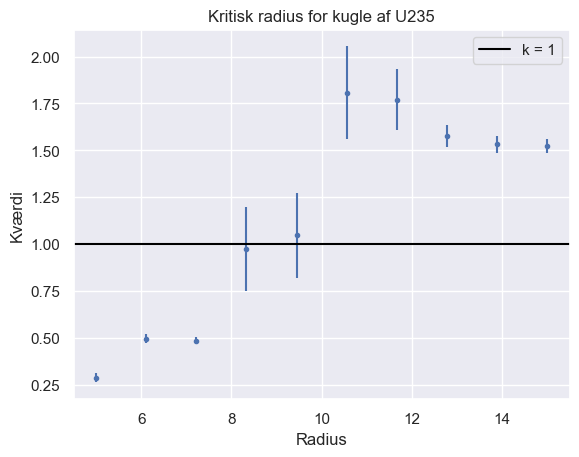

In [108]:
Y, Yerr = [], []
for j in range(antal):
    Y.append(np.mean(kværdier[j:-1:10]))
    Yerr.append(np.std(kværdier[j:-1:10])/np.sqrt(antal))

plt.errorbar(Radier[:antal],Y, Yerr, fmt = ".")
plt.xlabel("Radius")
plt.ylabel("Kværdi")
plt.axhline(y = 1, color = 'black', linestyle = '-', label = 'k = 1')
plt.legend()
plt.title("Kritisk radius for kugle af U235")
plt.show()

<h1> Klasser

ValueError: x and y must have same first dimension, but have shapes (746,) and (747,)

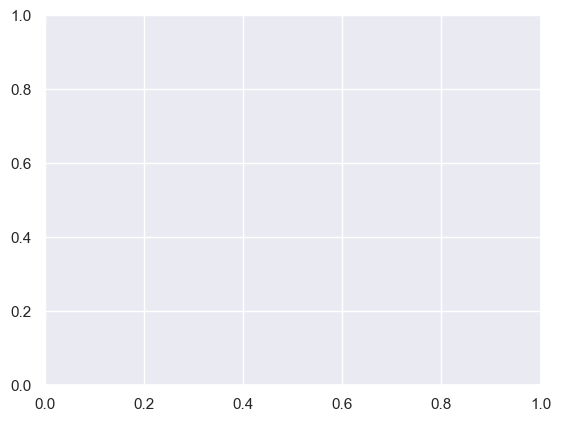

In [26]:
for i in range(len(k_value)):
    X = np.linspace(0,len((k_value[i])),len(k_value[i]))
    plt.plot(simtid[i],k_value[i], label = 'r_fuel = '+str(round(np.linspace(minr,maxr,antal)[i],2)))
plt.legend()
plt.axhline(y = 1, color = 'black', linestyle = '-', label = 'k = 1')
plt.ylabel('k-værdier')
plt.xlabel('tid')
plt.ylim(0.5,3.7)
plt.show()

# Y = []
# for i in range(antal):
#     Y.append(k_value[i][-1])
# plt.plot(np.linspace(minr,maxr,antal),Y, '.')
# plt.axhline(y = 1, color = 'black', linestyle = '-', label = 'k = 1')
# plt.ylabel('k-værdier')
# plt.xlabel('r_fuel')
# plt.legend()

In [27]:
for i in range(antal):
    kværdier[i] = np.mean(kværdier[i])
plt.plot(np.linspace(minr,maxr,antal),kværdier, '.')
plt.axhline(y = 1, color = 'black', linestyle = '-', label = 'k = 1')
plt.ylabel('k-værdier')
plt.xlabel('r_fuel')

IndexError: list index out of range

<h1> Simulationen

Antal interaktioner: 253
Energi frigivet: [10587.93636093] MeV
Antal neutroner tilbage:  113
Antal fissionsreaktioner: 59.5
Antal neutroner der har slippet ud:  59
Antal scattering events:  193
Antal Neutron capture events:  1


c:\Users\chril\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


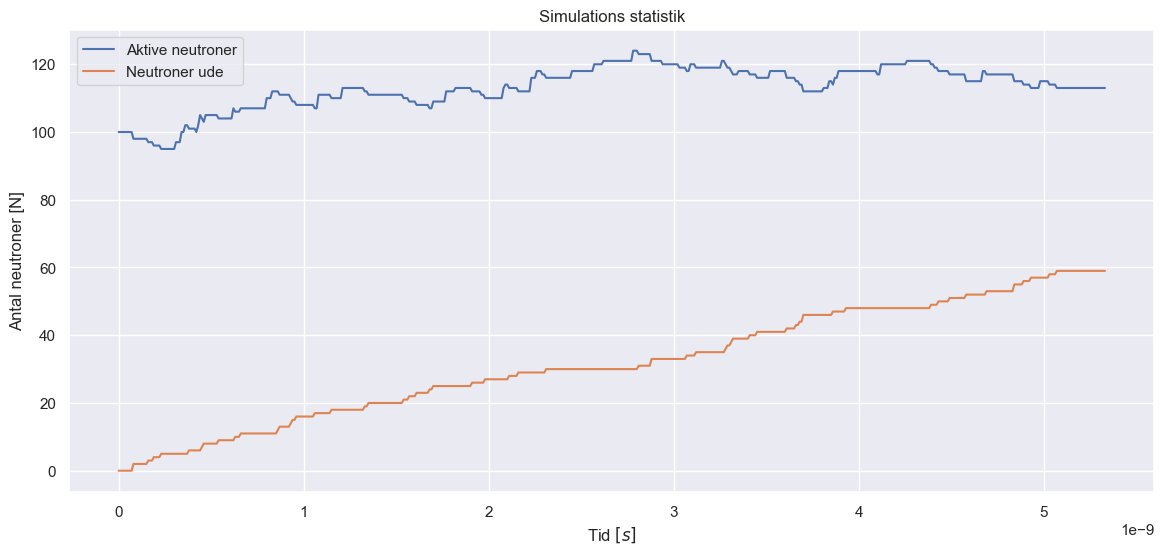

In [ ]:
#print(Neutroner)
#print(Datterkerner)
print('Antal interaktioner:', len(Q))
print('Energi frigivet: ' + str(np.sum(Q)) +' MeV')
print('Antal neutroner tilbage: ',len(Neutroner))
print('Antal fissionsreaktioner:', len(Datterkerner)/2)
print('Antal neutroner der har slippet ud: ', len(Neutroner_ude))
print('Antal scattering events: ', Scattering)
print('Antal Neutron capture events: ', Capture)
#print(Q)
plt.figure(figsize=(14,6))
plt.plot(Tid,Aktive_neutroner, label = 'Aktive neutroner')
plt.plot(Tid,Ude_neutroner_t,label = 'Neutroner ude')
plt.title('Simulations statistik')
plt.xlabel('Tid $[s]$')
plt.ylabel('Antal neutroner [N]')
plt.legend()
plt.show()